# Mitigating Gender Bias on UCI Adult Dataset

This tutorial explores the topic of bias in Machine Learning using the UCI Adult dataset. It provides familiarity with the concept of bias in Machine Learning, explores different metrics used to quantify bias in machine learning, and demonstrates data and model-based approaches to mitigating bias in Machine Learning.


### Software requirements

This tutorial requires python3 and jupyter notebook installed. In addition, you will need **[numpy](https://www.numpy.org/) and [pandas](https://pandas.pydata.org/)**, which standard data science libraries, and **[skit-learn](https://scikit-learn.org/stable/)**, which is a machine learning library.

# I. Understanding UCI Adult dataset

In this section, we will look through the data that we have. This will give us an idea of the underlying distributions of the data among different demographics.

## Load needed modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Load the dataset ##

Download preprocessed UCI adult dataset from [our github repository](https://github.com/heyaudace/ml-bias-fairness/blob/master/data/adult/adult.csv), and store it on your local machine

In [2]:
import os
ADULT_PATH = os.path.join(os.getcwd(), 'data/adult/adult.csv') # Assign this to the location of the dataset

In [3]:
data = pd.read_csv(ADULT_PATH)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
# Ge the shape of the data
data.shape

(48842, 15)

Let's understand the amount of data by we have, by seeing how the number of datapoints compares among different demographics

In [5]:
def plot_categs(df, category, fignum=1, title="Histogram of number of datapoints"):
    plt.figure(fignum)
    uniques= list(sorted(df[category].unique()))
    counts = [df[df[category] == value].shape[0] for value in uniques]
    size = len(uniques)
    xcoords = list(range(1, size+1))
    plt.bar(xcoords, counts)
    plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
    plt.title((title if title is not None else ''))
    plt.tight_layout()

## Sex, Race and Native Country

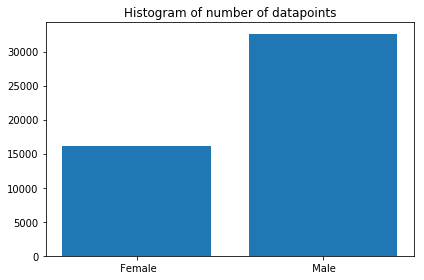

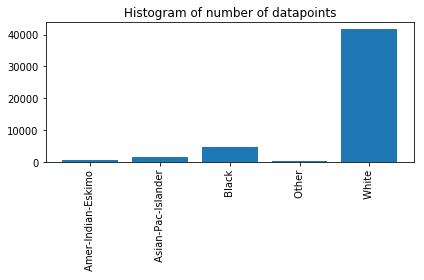

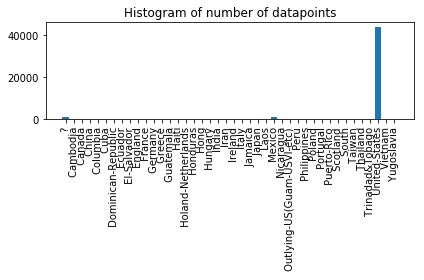

In [6]:
features = ['sex', 'race', 'native-country']
for index, feature in enumerate(features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of education level and occupation

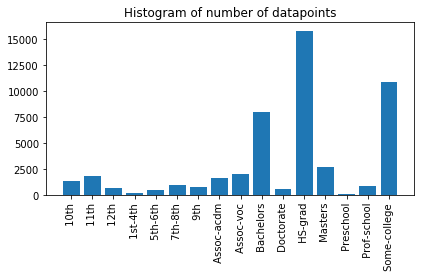

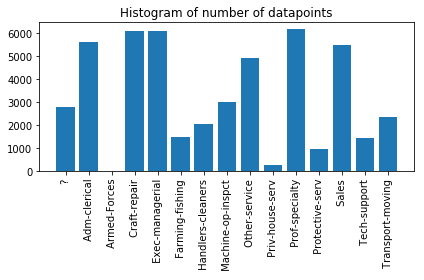

In [7]:
other_features = ['education', 'occupation']
for index, feature in enumerate(other_features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of salary among the general population

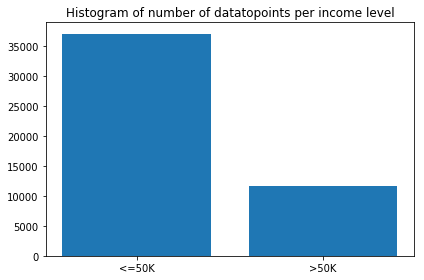

In [8]:
plot_categs(data, 'salary', title="Histogram of number of datatopoints per income level")

## CHECKPOINT 
The fraction of the population that makes less than 50K is about 3 times the fraction of the
population that earns more than 50K.How would this affect the predictor trained on this data?

# Distribution of salary among people of different gender

Let's now explore the distribution of salary among people of Male sex versus people with Female sex

In [9]:
def subplot_categs(dfs, titles, category, fignum=1):
    plt.figure(fignum, figsize=(12, 6))
    number_of_dfs = len(titles)
    first_axis = None
    for df_index, df in enumerate(dfs):
        title = titles[df_index]
        uniques = list(sorted(df[category].unique()))
        counts = [df[df[category]==value].shape[0] for value in uniques]
        size = len(uniques)
        xcoords = list(range(1, size+1))
        if df_index == 0:
            first_axis =plt.subplot(1, 2, df_index+1)
        else:
            new_axis = plt.subplot(1, 2, df_index + 1, sharey=first_axis)
        plt.bar(xcoords, counts)
        plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
        plt.title((title if title else ''))
        plt.tight_layout()

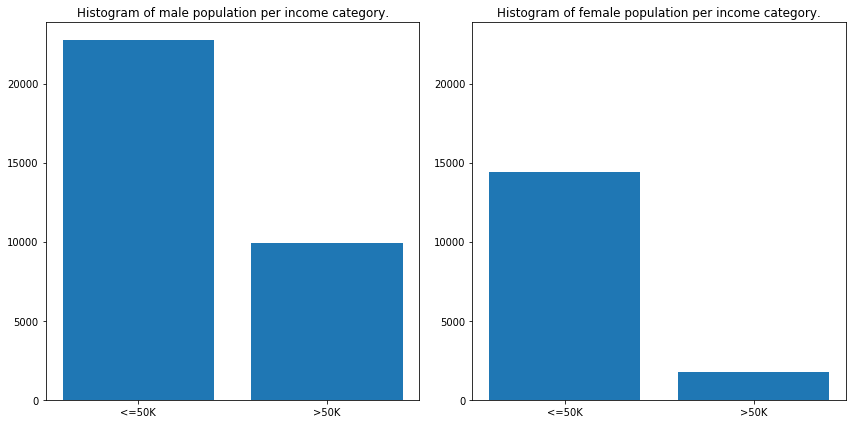

In [10]:
# Examining income category distribution among the male and female demographics
male_data = data[data.sex == ' Male']
female_data = data[data.sex == ' Female']
titles = ['Histogram of male population per income category.', 'Histogram of female population per income category.']
subplot_categs([male_data, female_data], titles, 'salary')


**Key observation:** 
- The number of datapoints in the male population is considerably higher than the number of datapoints in the female category, exceeding it by more than 3 times in the higher income category.

**THINK**:
- How might this representation disparity affect predictions of a model trained on this data?**

## Distribution of race in the dataset

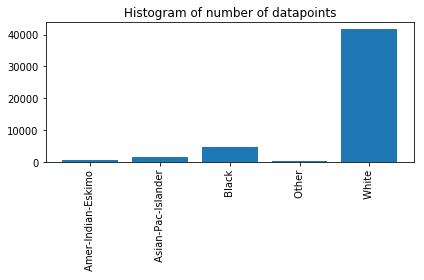

In [11]:
# Examine races in the dataset
plot_categs(data, 'race')

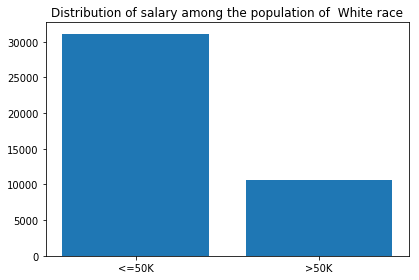

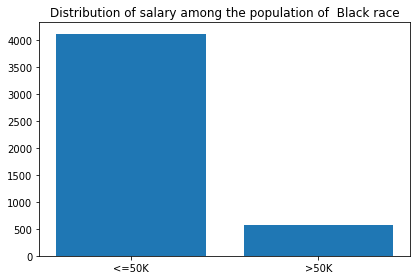

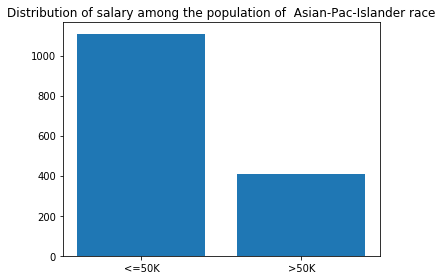

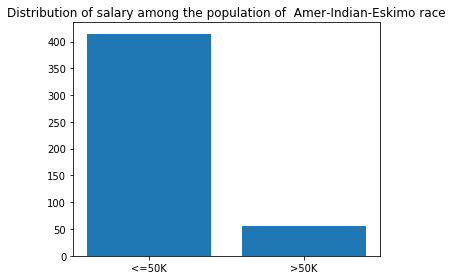

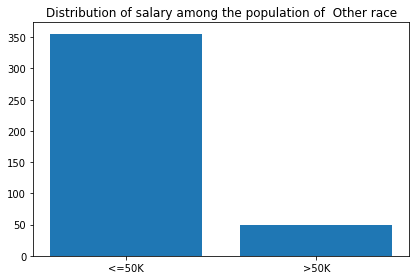

In [12]:
unique_races = data['race'].unique()
for index, race in enumerate(unique_races):
    plot_categs(data[data['race'] == race], 'salary', fignum=index, title = "Distribution of salary among the population of "+race+" race")

**Key observation**:
- Different races have different levels of representation in terms number of datapoints with a given race
- The levels of income distribution among a given race are different 

**THINK**:
- How could this representation disparity affect a model trained on this data?

#  Distribution of hours per week

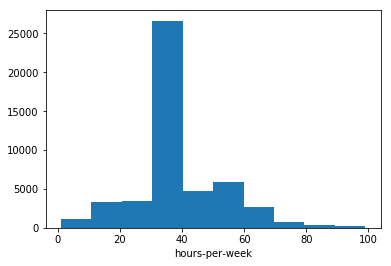

In [13]:
def plot_categ_hists(df, feature, title=None, bins=None, histtype='bar', density=False, normed=None, fignum=1):
    plt.figure(fignum)
    x = df[feature]
    plt.hist(x, bins=bins, density=density, normed=normed, histtype=histtype)
    plt.xlabel(feature)
    plt.title(title if title is not None else '')
plot_categ_hists(data, 'hours-per-week', fignum=1)

# II. Preparing data for predictions

One important step in data science before applying machine learning algorithms is data preparation. In this section, we will be transforming features of our data, so that our dataset can be ready for machine learning

In [14]:
# Create a new dataset to be modified 
datav2 = data.copy()
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Drop missing values
Some of the entries in our dataset are either question marks (' ?') or np.nan. Let's simply ignore such entries

In [15]:
# See features with question marks
[feature for feature in datav2.columns if ' ?' in datav2[feature].unique() or np.nan in datav2[feature].unique()]

/Users/audace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


['workclass', 'occupation', 'native-country']

In [16]:
# Remove all missing values
for feature in datav2.columns:
    datav2[feature] = datav2[feature].replace(' ?', np.nan)
datav2.dropna(how='any', inplace=True)

datav2['native-country'].unique(), datav2['workclass'].unique(), datav2['occupation'].unique()

(array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
        ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
        ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
        ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
        ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
        ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
        ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
        ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
        ' Hungary', ' Holand-Netherlands'], dtype=object),
 array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
        ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object),
 array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
        ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
        ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
        ' Craft-repai

## Convert native country to binary one-hot for US vs non-US

In [17]:
datav2[datav2['native-country'] == ' United-States'].shape

(41292, 15)

In [18]:
datav2.loc[datav2['native-country']!=' United-States', 'native-country'] = 'Non-US'
datav2.loc[datav2['native-country'] == ' United-States', 'native-country'] = 'US'
US_LABEL, NON_US_LABEL = (0, 1)
datav2['native-country'] = datav2['native-country'].map({'US':US_LABEL,'Non-US':NON_US_LABEL}).astype(int)
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,0,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,0,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,0,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,0,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,1,<=50K


# Convert sex and salary to binary one-hot

In [19]:
FEMALE_LABEL, MALE_LABEL = (0, 1)
HIGH_SALARY_LABEL, LOW_SALARY_LABEL = (0, 1)

In [20]:
datav2['salary'] = datav2['salary'].map({'>50K':HIGH_SALARY_LABEL,'<=50K':LOW_SALARY_LABEL})
datav2['sex'] = datav2['sex'].map({' Male':MALE_LABEL,' Female':FEMALE_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Change marital status to single or couple

In [21]:
datav2['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [22]:
datav2['marital-status'] = datav2['marital-status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],'Single')
datav2['marital-status'] = datav2['marital-status'].replace([' Married-AF-spouse',' Married-civ-spouse'],'Couple')
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Single,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Couple,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Single,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Couple,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Couple,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


In [23]:
COUPLE_STATUS_LABEL, SINGLE_STATUS_LABEL = (0, 1)
datav2['marital-status'] = datav2['marital-status'].map({'Couple':COUPLE_STATUS_LABEL,'Single':SINGLE_STATUS_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Convert relationships to one-hot

Remember that one-hot encoding helps us represent data of multiple categories. Let's do this for relationships

In [24]:
# First convert relationship to integers
rel_map = {' Unmarried':0,' Wife':1,' Husband':2,' Not-in-family':3,' Own-child':4,' Other-relative':5}
datav2['relationship'] = datav2['relationship'].map(rel_map)
datav2.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,3,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,2,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,3,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,2,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,1,Black,0,0.0,0.0,40.0,1,1
5,37,Private,284582.0,Masters,14.0,0,Exec-managerial,1,White,0,0.0,0.0,40.0,0,1
6,49,Private,160187.0,9th,5.0,1,Other-service,3,Black,0,0.0,0.0,16.0,1,1
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,0,Exec-managerial,2,White,1,0.0,0.0,45.0,0,0
8,31,Private,45781.0,Masters,14.0,1,Prof-specialty,3,White,0,14084.0,0.0,50.0,0,0
9,42,Private,159449.0,Bachelors,13.0,0,Exec-managerial,2,White,1,5178.0,0.0,40.0,0,0


In [25]:
# Now convert relationship from integer to one-hot
datav2 = pd.get_dummies(datav2, columns=['relationship'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,White,1,2174.0,0.0,40.0,0,1,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,White,1,0.0,0.0,13.0,0,1,0,0,1,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,White,1,0.0,0.0,40.0,0,1,0,0,0,1,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Black,1,0.0,0.0,40.0,0,1,0,0,1,0,0,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Black,0,0.0,0.0,40.0,1,1,0,1,0,0,0,0


##  Convert race to one-hot

As we did for relationships, we know convert race representation to one-hot encoding

In [26]:
# Convert to integers first
race_map={' White':0,' Amer-Indian-Eskimo':1,' Asian-Pac-Islander':2,' Black':3,' Other':4}
datav2['race']= datav2['race'].map(race_map)
# Convert from integer to one_hot
datav2 = pd.get_dummies(datav2, columns=['race'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,...,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,race_0,race_1,race_2,race_3,race_4
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,...,0,0,1,0,0,1,0,0,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0


# Transform workclass feature

We first start by categorizing workclass as government, private or without pay

In [27]:
def group_workclass(x):
    if x['workclass'] == ' Federal-gov' or x['workclass']== ' Local-gov' or x['workclass']==' State-gov': return 'govt'
    elif x['workclass'] == ' Private':return 'private'
    elif x['workclass'] == ' Self-emp-inc' or x['workclass'] == ' Self-emp-not-inc': return 'self_employed'
    else: return 'without_pay'
    
datav2['workclass']=datav2.apply(group_workclass, axis=1)

datav2['workclass'] = datav2['workclass'].map({'govt':0,'private':1,'self_employed':2,'without_pay':3})
datav2 = pd.get_dummies(datav2, columns=['workclass'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,...,relationship_5,race_0,race_1,race_2,race_3,race_4,workclass_0,workclass_1,workclass_2,workclass_3
0,39,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,40.0,...,0,1,0,0,0,0,1,0,0,0
1,50,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,13.0,...,0,1,0,0,0,0,0,0,1,0
2,38,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,40.0,...,0,1,0,0,0,0,0,1,0,0
3,53,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0
4,28,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0


# Convert occupation to one-hot

In [28]:
occupation_map = dict((value, key) for (key, value) in enumerate(datav2.occupation.unique()))
datav2['occupation'] = datav2['occupation'].map(occupation_map)
datav2 = pd.get_dummies(datav2, columns=['occupation'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,2174.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


##  Convert capita-gain and capital-loss to categorical

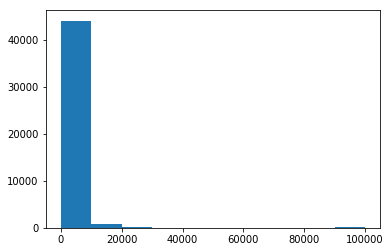

In [29]:
capital_gain, capital_loss, =datav2['capital-gain'], datav2['capital-loss']
plt.hist(capital_gain,bins=None,normed=None)
plt.show()

In [30]:
datav2.loc[(datav2['capital-gain'] > 0),'capital-gain'] = 1
datav2.loc[(datav2['capital-gain'] == 0 ,'capital-gain')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


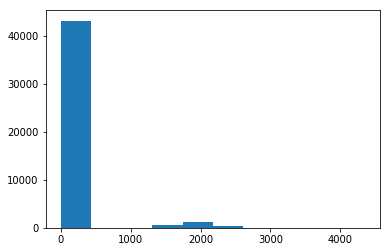

In [31]:
x=datav2['capital-loss']
plt.hist(x,bins=None)
plt.show()

In [32]:
datav2.loc[(datav2['capital-loss'] > 0),'capital-loss'] = 1
datav2.loc[(datav2['capital-loss'] == 0 ,'capital-loss')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


# III. Predicting individual's income, no debiasing

In [33]:
# Normalize continuous features
continuous_features = ['age', 'fnlwgt', 'education-num', 'hours-per-week']
X = datav2[continuous_features]
datav2[continuous_features] = (X - np.mean(X))/ np.std(X)
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,Bachelors,1.128753,1,1,1.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,Bachelors,1.128753,0,1,0.0,0.0,-2.326738,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,HS-grad,-0.438122,1,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,11th,-1.221559,0,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,Bachelors,1.128753,0,0,0.0,0.0,-0.078120,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
datav2 = datav2.drop(['education'], axis=1)

# Train a machine learning algorithm on the data

We will train a classifier on the dataset, and use it to make predictions.
Let's use a Multi-layer Perceptron classifier with default parameters. This model optimizes the log-loss function using LBFGS or stochastic gradient descent. Checkout [Multi-layer Perceptron(MLPClassifier)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to learn how you can customize it.

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [36]:
def get_naive_dataset(dataset):
    data_shuffled = dataset.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop(['salary'], axis=1)
    y = data_shuffled['salary']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    return (x_train, y_train), (x_test, y_test)

In [37]:
MLP_MAX_ITER=10000

In [38]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav2)
model = MLPClassifier(max_iter=MLP_MAX_ITER)
model.fit(x_train,y_train)
prediction = model.predict(x_test)

# Evaluating algorithm's performance

In [39]:
test_df = x_test.copy()
test_df['salary'] = y_test
test_df['pred'] = pd.Series(prediction, index=test_df.index)
test_df['accurate'] = (test_df['pred'] == test_df['salary'])
test_df.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary,pred,accurate
25873,0.715105,0.015660,-0.046403,1,0,0.0,0.0,0.754701,0,1,...,0,0,0,0,0,0,0,1,1,True
8523,1.320353,-0.526153,-1.613277,0,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,1,1,True
2761,0.109857,2.313052,-0.438122,1,0,0.0,0.0,-0.078120,0,0,...,0,1,0,0,0,0,0,1,1,True
27537,-0.495391,-0.027933,1.128753,0,0,1.0,0.0,0.338291,0,0,...,0,0,0,0,0,0,0,1,0,False
16241,-1.176295,-1.403876,1.128753,1,0,0.0,0.0,-2.160174,0,0,...,0,0,0,0,0,0,0,1,1,True


In [40]:
"Accuracy: ", test_df.accurate.mean()

('Accuracy: ', 0.834954891208208)


# Understanding gender bias in machine learning predictions


In [41]:
def evaluate_gender_performance(results_df, print_stats=False):
    """
    TODO: 
        - method documentation
        - DRYing
    """
    def printline():
        _print('-------------------------------------------------')
        
    def _print(*args, **kwargs):
        if print_stats:
            print (args, kwargs)
    
    summaries = {}
    overall_accuracy = results_df.accurate.mean()
    summaries['accuracy_overall'] = overall_accuracy
    printline()
    _print("\n1.Overall accuracy: ", overall_accuracy)
    
    printline()
    
    # Accuracy accross gender
    _print("\n2.Accuracy accross gender \n ")
    printline
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        accuracy_for_gender = rows.accurate.mean();
        summaries['accuracy_'+gender[1]] = accuracy_for_gender
        _print("P(((high, HIGH) or (low, LOW)) |", gender[1], "): ", accuracy_for_gender)
    printline()
    
    _print("\n3.Positive Rates: \n")
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==HIGH_SALARY_LABEL).mean()
        summaries['positive_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(high|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    _print("\n4. Negative Rates: \n")
    
    # Low income rate given gender
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==LOW_SALARY_LABEL).mean()
        summaries['negative_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(low|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    _print("\n4. True positive and True negative rates")
    
    printline()
    
    for index, gender in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):
        
        _print("\n4."+("i")*(1+index), " True positive and negative rates on sex="+gender[1], "\n")
        rows = results_df[results_df.sex==gender[0]]
        
        high_income = rows[rows.salary== HIGH_SALARY_LABEL]
        low_income=rows[rows.salary == LOW_SALARY_LABEL]
        if high_income.shape[0] > 0:
            assert high_income.salary.mean() == HIGH_SALARY_LABEL, "high_mean: " + str(high_income.salary.mean())
        if low_income.shape[0] > 0:
            assert low_income.salary.mean() == LOW_SALARY_LABEL, "low_mean: " + str(low_income.salary.mean())
        
        high_pred = rows[rows.pred == HIGH_SALARY_LABEL]
        low_pred = rows[rows.pred == LOW_SALARY_LABEL]
        if high_pred.shape[0] > 0:
            assert high_pred.pred.mean() == HIGH_SALARY_LABEL, "high_pred_mean: " + str(high_pred.pred.mean())
        if low_pred.shape[0] > 0:
            assert low_pred.pred.mean() == LOW_SALARY_LABEL, "low_pred_mean: " + str(low_pred.pred.mean())
        
        printline() 
        true_positive_rate = high_income.accurate.mean()
        true_negative_rate = low_income.accurate.mean()
        summaries['true_positive_rate_'+gender[1]] = true_positive_rate
        summaries['true_negative_rate_'+gender[1]] = true_negative_rate
        
        _print(str.format("P((high, HIGH)| HIGH,{0})", gender[1]), ": ",true_positive_rate)
        _print(str.format("P((low, LOW)| LOW,{0})", gender[1]), ":",true_negative_rate)
        
        printline()
        #true_positive_rate_on_positive_predictions = high_pred.accurate.mean()
        #true_negative_rate_on_negative_predictions = low_pred.accurate.mean()
        #summaries['true_positive_rate_on_positive_predictions_'+gender[1]] = true_positive_rate_on_positive_predictions
        #summaries['true_negative_rate_on_negative_predictions_'+gender[1]] = true_negative_rate_on_negative_predictions
        #_print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",true_positive_rate_on_positive_predictions)
        #_print(str.format("P((low,LOW) |low,{0})", gender[1]), ":", true_negative_rate_on_negative_predictions)
        
        
    return summaries

def plot_performance_per_group(accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):
    
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
    
    
    indices = [0]
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
        
    #plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    
    
def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):    
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
    
    
    indices = list(range(len(approaches)))
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
        
    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    
def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature+'_Male'] for summary in _summaries], 
                         [summary[_feature+'_Female'] for summary in _summaries]
                        ]
    plot_comparisons_groups(_modelNames,gender_metrics, _title, rotation=rotation)

def model_summary(model_name, title, summary):
    summaries = []
    model_names = []
    
    for key in ["accuracy", "positive_rate", "negative_rate", "true_positive_rate", "true_negative_rate"]:
        new_summary = {"accuracy_Male": summary[key+"_Male"], "accuracy_Female": summary[key+"_Female"]}
        summaries.append(new_summary)
        model_names.append(key)   
    plot_model_gender_metrics("accuracy", summaries, model_names, model_name)
    #plot_model_gender_metrics(key, [summary], [model_name], "Model="+model_name+", Metric="+key, rotation="horizontal")
        

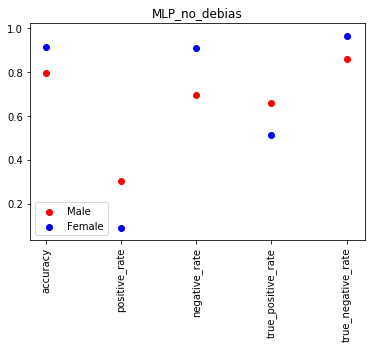

In [42]:
original_approach = evaluate_gender_performance(test_df)
model_summary("MLP_no_debias", "", original_approach)

# Plot learning curve

In [43]:
default_training_sizes = [1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, lrxtrain, lrytrain, train_sizes, title=None):
    _train_sizes = []
    for size in train_sizes:
        if size <= lrxtrain.shape[0]*.65:
            _train_sizes.append(size)
        else:
            break
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, lrxtrain, lrytrain, train_sizes = _train_sizes, scoring = 'neg_log_loss')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('NLL', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

In [44]:
#plot_learning_curve(MLPClassifier(), X, y, default_training_sizes, "Learning curve, Naive approach")

## Introducing Bias metrics

The two most used bias metrics are **statistical parity**, and **equality of opportunity**.

# IV. Bias mitigation Techniques

In this section, we will be exploring two main techniques for reducing bias in machine learning. The first technique is called unawareness, and the second technique is database re-balancing.

## IV.1 Mitigation through unawareness

In this technique, we attempt to decrease algorithmic bias by removing sensitive/protected attributes from training data. This is called unawareness. 

In [45]:
def get_unawareness_dataset(dataset):
    (x_train, y_train), (x_test, y_test) = get_naive_dataset(dataset)
    testdata = x_test.copy()
    assert "sex" in list(testdata.columns), ("columns: ", list(testdata.columns))
    
    x_train, x_test = [v.drop(['sex'], axis=1) for v in (x_train, x_test)]
    return (x_train, y_train), (x_test, y_test), testdata

In [46]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
(x_train, ytrain), (x_test, y_test), testdata = get_unawareness_dataset(datav2)
predictor.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [47]:
def evaluate_predictor_performance(predictions, x_test, y_test):
    """
    Returns summary statistics for the predictor's performance
    
    Input:
        - predictions: model's predictions on x_test
        - x_test: test input
        - y_test: test labels
        
    Requires:
        - predictor must have been fitted on x_train and y_train from the same dataset
    
    Check method evaluate_gender_performance for more on the produced summary statistics
    """
    testdata = x_test.copy()
    testdata['salary'] = y_test
    testdata['pred'] = pd.Series(predictions, index=x_test.index)
    testdata['accurate'] = (testdata['pred'] == testdata['salary'])
    return evaluate_gender_performance(testdata)

# Analysing performance

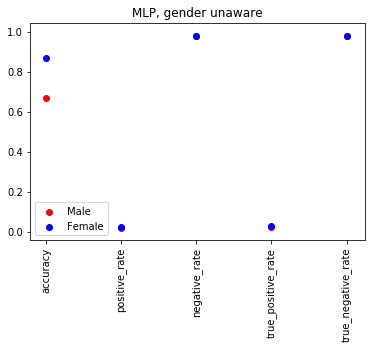

In [48]:
predictions = predictor.predict(x_test)
approach_1 = evaluate_predictor_performance(predictions, testdata, y_test)
model_summary("MLP, gender unaware", "", approach_1)

In [49]:
# TODO: Change X, Y
#plot_learning_curve(MLPClassifier(), X, y, default_training_sizes, 'Learning curves, Unawareness')

## IV.2 Mitigation through dataset balancing

### IV.2.1 Equal number of datapoints per demographic

In this approach, we attempt to balance the dataset by drawing equal number of samples from the male and female demographics.

In [50]:
def get_gender_balanced_dataset(dataset, test_size=0.25):
    """
    Returns (x_train, y_train), (x_test, y_test) with equal number of samples for each gender
    """
    males, females = dataset[dataset.sex == MALE_LABEL], dataset[dataset.sex==FEMALE_LABEL]
    sampled_males = males.sample(n=int(min(females.shape[0], males.shape[0]))).reset_index(drop=True)
    combined = pd.concat([sampled_males, females]).sample(frac=1).reset_index(drop=True)
    Xvals=combined.drop(["salary"], axis=1)
    Yvals = combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)
    

In [51]:
datav3 = datav2.copy()
datav3.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,1.128753,1,1,1.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,1.128753,0,1,0.0,0.0,-2.326738,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,-0.438122,1,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,-1.221559,0,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,1.128753,0,0,0.0,0.0,-0.078120,1,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
(x_train, y_train), (x_test, y_test) = get_gender_balanced_dataset(datav3)
x_train.shape, x_test.shape

((22042, 38), (7348, 38))

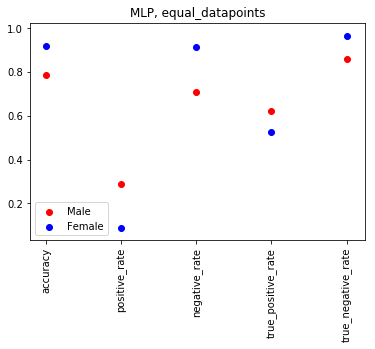

In [53]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
approach_2 = evaluate_predictor_performance(predictor.predict(x_test), x_test, y_test)
model_summary("MLP, equal_datapoints", "", approach_2)

In [54]:
# TODO: Set to correct values
#plot_learning_curve(MLPClassifier(), Xvals, Yvals, default_training_sizes, 'Learning curve, 3.2')

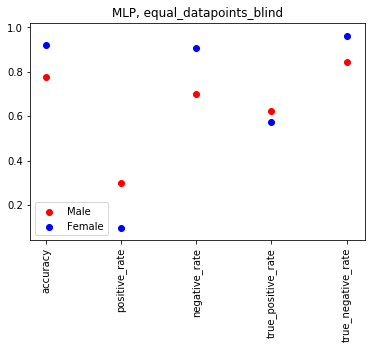

In [55]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
approach_2_blind = evaluate_predictor_performance(predictor.predict(x_test.drop(['sex'], axis=1)), x_test, y_test)
model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

### IV.2.2 Equal number of datapoints per demographic in each category

In this approach, we draw an equal number of data points from the subset of male individuals with a high income, male individuals with a low income, female individuals with a high income and female individuals with a low income

In [56]:
# TODO: Implement random sampling
def get_gender_category_balanced_dataset(dataset, test_size=0.25):
    """
    Equal number of datapoints per category. Limited by the smallest number of points
    """
    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]
    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]
    
    # Smallest is the bottleneck
    smallest = min((x.shape[0] for x in [male_high, male_low, female_high, female_low]))
    
    # New distribution categories
    _male_high = male_high.sample(n=smallest).reset_index(drop=True)
    _male_low = male_low.sample(n=smallest).reset_index(drop=True)
    _female_high = female_high.sample(n=smallest).reset_index(drop=True)
    _female_low = female_low.sample(n=smallest).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)
    
    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)

**Think:** Note how the size of the training set has changed

We now train a new predictor on this new dataset

In [57]:
(x_train, y_train), (x_test, y_test) = get_gender_category_balanced_dataset(datav3)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

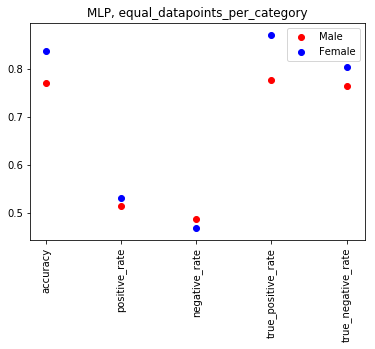

In [58]:
approach_3 = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_datapoints_per_category", "", approach_3)

**Equal datapoints, gender_unaware**

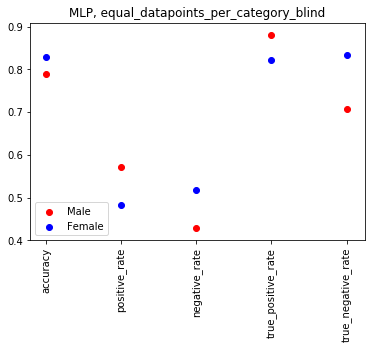

In [59]:
(x_train, y_train), (x_test, y_test) = get_gender_category_balanced_dataset(datav3)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = predictor.predict(x_test.drop(['sex'], axis=1))
approach_3_blind = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_datapoints_per_category_blind", "", approach_3_blind)

### IV.2.3 Equal ratios instead of equal number of datapoints

In this section, we balance the dataset by preserving the ratio of the the size of the population in a given demographic with a given income level in a way that maximizes the number of datapoints.

In [60]:
def get_gender_category_ratio_balanced_dataset(dataset):
    
    """
    Ratio of (male_high, male_row) = Ratio of (female_high, female_low), maximize number of real datapoints
    """
    
    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    assert males.shape[0] > 0 and females.shape[0] > 0, "Empty males or females"
    
    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]
    
    assert male_high.shape[0] > 0 and male_low.shape[0] > 0, " empty male high or low"
    
    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]
    
    assert female_high.shape[0] > 0 and female_low.shape[0] > 0, "empty female high or low"
    
    
    print("shapes mh, ml, fh, fl: ", [x.shape[0] for x in [male_high, male_low, female_high, female_low]])
    
    ratio = float(male_high.shape[0]) / float(male_low.shape[0])
    assert ratio > 0, " ratio must be greater than 0"
    
    print ("Ratio is ", ratio)
    n_female_high = female_high.shape[0]
    n_female_low = int(n_female_high / ratio)

    _male_low = male_low.copy()
    _male_high = male_high.copy()
    _female_high = female_high.copy()
    _female_low = female_low.sample(n=n_female_low).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)
    
    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)
    
    return (x_train, y_train), (x_test, y_test)
    

**Explanation** :
Among the 4 subsets, the smallest one is the subset of female individuals who earn a high income. In this section, instead of restricting the size of all other subsets to this size in our new distribution, we can instead create a new distribution that preserves either the ratio of female individuals who earn high income to the ratio of female individuals who earn low income, or the ratio of male individuals who earn high income to the ratio of male individuals who earn low income.

In the example above, we ensure that the ratio of the number of male individuals who earn a high income to the ratio of the number of female individuals who earn a low income is equal to the ratio of female individuals who earn a high income to the ratio of female individuals who earn a low income.

This has an advantage of being able to use more data points for our training set than the previous approach.

In [61]:
datav3.shape

(45222, 39)

In [62]:
(x_train, y_train), (x_test, y_test) = get_gender_category_ratio_balanced_dataset(datav3)
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

shapes mh, ml, fh, fl:  [9539, 20988, 1669, 13026]
Ratio is  0.4544978082713932


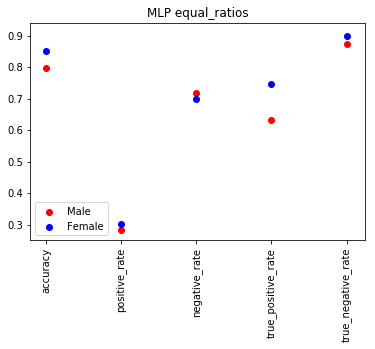

In [63]:
approach_4 = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP equal_ratios", "", approach_4)

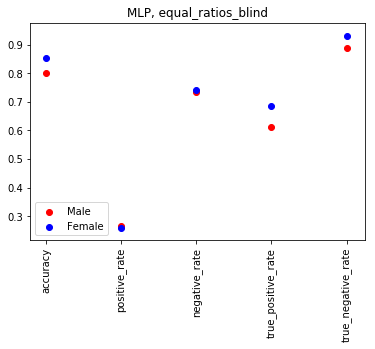

In [64]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = predictor.predict(x_test.drop(['sex'], axis=1))
approach_4_blind = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_ratios_blind", "", approach_4_blind)

# IV. Bias mitigation through data augmentation

In this sectionn we explore bias mitigation approaches that augment existing data with synthetic examples

## IV.1 Counterfactual augmentation

In [65]:
def with_gender_counterfacts(df):
    df_out = df.copy()
    df_out['sex'] = df_out['sex'].apply(lambda value: 1-value)
    result = pd.concat([df.copy(), df_out])
    return result

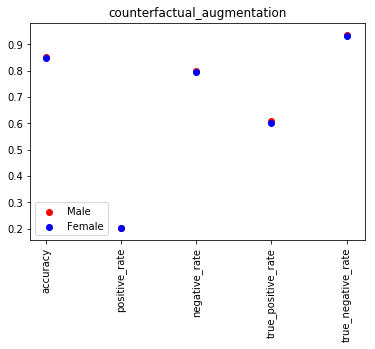

In [66]:
ctf_gender_augmented = with_gender_counterfacts(datav2)
(x_train, y_train), (x_test, y_test) = get_naive_dataset(ctf_gender_augmented)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
ctf_1 = evaluate_predictor_performance(predictor.predict(x_test), x_test, y_test)
model_summary("counterfactual_augmentation", "", ctf_1)

In [67]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

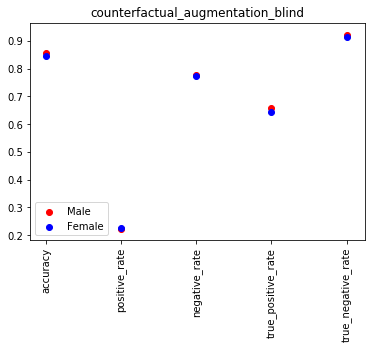

In [68]:
ctf_blind = evaluate_predictor_performance(predictor.predict(x_test.drop(['sex'], axis=1)), x_test, y_test)
model_summary("counterfactual_augmentation_blind", "", ctf_blind)

# V. Comparing bias mitigation approaches

- In the naïve approach, we trained on the entire dataset
- In approach 2, we used gender from our features ( unawareness )
- In approach 3, we  used dataset with equal number of samples from the male and female demographics
- In approach 4, we used a dataset with equal number of samples within each income category for the male and female demographics
- In approach 5, we used a dataset with same ratio of number of samples within each income category for the male and female demographics.

In this section, we will be comparing the results of these different approaches

In [69]:
def plot_comparisons(approach_names, accuracy_results, title, fignum=1, rotation='horizontal'):
    """
    Args:
        - summary: Dictionary describing the approach's gender performance
        - approach_name: The name of the technique, to be displayed
    """
    assert isinstance(accuracy_results, list) and not isinstance(accuracy_results[0], list), accuracy_results
    
    
    indices = list(range(len(approach_names)))
    colors = cm.rainbow(np.linspace(0, 1, len(indices)))
    plt.figure(fignum)
    
    for index in indices:
        plt.scatter(index, accuracy_results[index], color=colors[index])
        
    plt.xticks(indices, approach_names, rotation=rotation)
    
    plt.title(title)
    plt.show()
    
def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):    
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
    
    
    indices = list(range(len(approaches)))
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
        
    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    

In [70]:
approaches = ['no_debias', 'gender_unaware', 'equal_|data|_per_gender', 'if_gender_blind', 'equal_data_per_(gender, category)', 'if_gender_blind' 'equal_data_ratio_per_gender', 'if_blind', 'ctf', 'ctf_blind']
summaries = [original_approach, approach_1, approach_2, approach_2_blind, approach_3, approach_3_blind, approach_4, approach_4_blind, ctf_1, ctf_blind]

# Comparing overall accuracies

Here we compare the overall accuracies of each of the 4 approaches

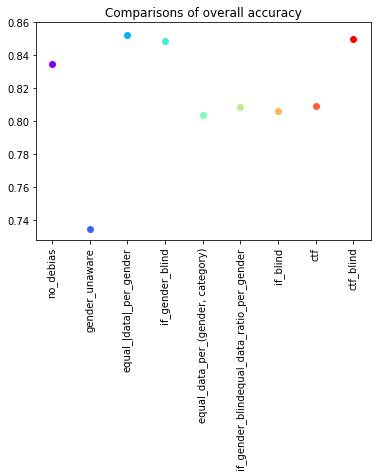

In [71]:

accuracy_results = [summary['accuracy_overall'] for summary in summaries]
plot_comparisons(approaches, accuracy_results, 'Comparisons of overall accuracy', rotation='vertical')

In [72]:
def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature+'_Male'] for summary in _summaries], 
                         [summary[_feature+'_Female'] for summary in _summaries]
                        ]
    plot_comparisons_groups(_modelNames,gender_metrics, _title, rotation=rotation)
    

# Comparing overall accuracy accross gender

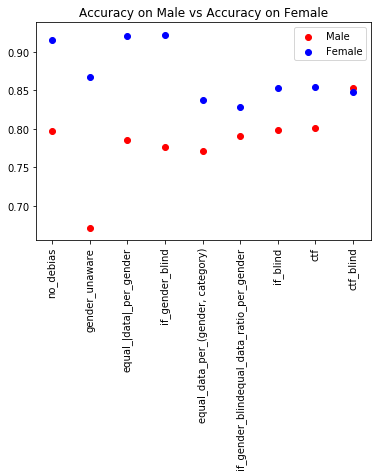

In [73]:
plot_model_gender_metrics('accuracy', summaries, approaches, "Accuracy on Male vs Accuracy on Female")

# Positive and negative rates accross gender

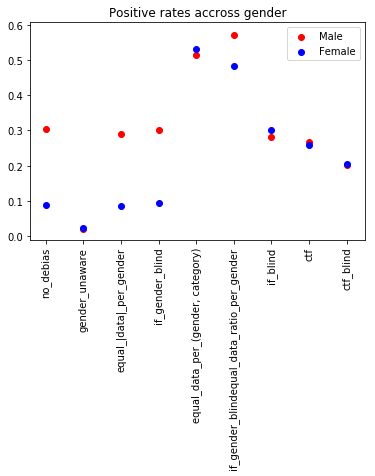

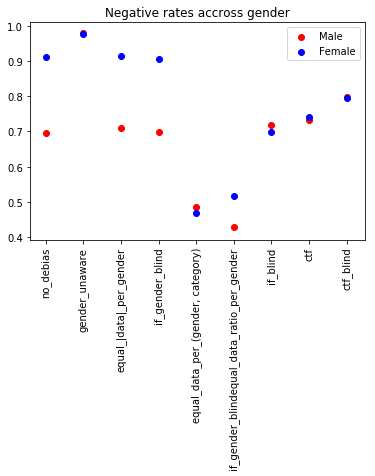

In [74]:
plot_model_gender_metrics('positive_rate', summaries, approaches, "Positive rates accross gender")
plot_model_gender_metrics('negative_rate', summaries, approaches, "Negative rates accross gender")

# True positive and True negative rates accross gender

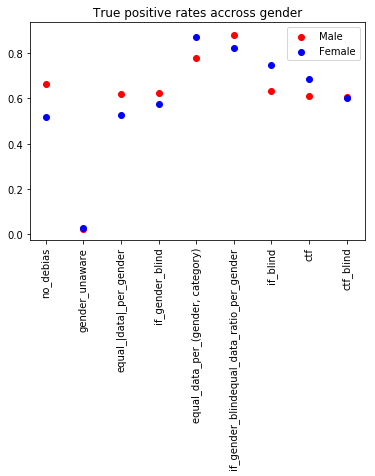

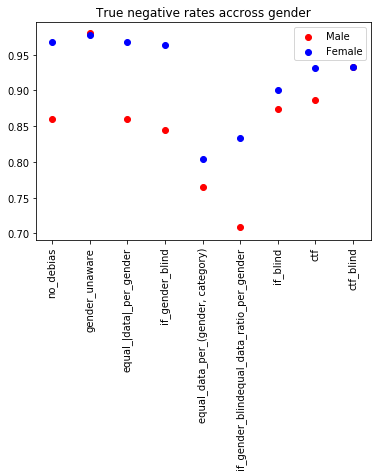

In [75]:
plot_model_gender_metrics('true_positive_rate', summaries, approaches, "True positive rates accross gender")
plot_model_gender_metrics('true_negative_rate', summaries, approaches, "True negative rates accross gender")

# True positive rate on positive predictions, and true negative rate on negative predictions


In [76]:
#plot_model_gender_metrics('true_positive_rate_on_positive_predictions', summaries, approaches, "True positive rates on positive predictions")
#plot_model_gender_metrics('true_negative_rate_on_negative_predictions', summaries, approaches, "True negative rates on negative predictions")

# Equalizing opportunity by setting equal true positive and true negative rates for different demographics

We will use the Receive Operating Characteristic(ROC) curve to understand how true positive and true negative rates affect each other accross different demographics


* Diagnostic ability of classifier
* Plots true positive rate (TPR) against the false positive rate (FPR) at various threshold settings
$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$
* Area under the ROC curve (AUC) - single number which reflects model's performance 

In [77]:
from sklearn import svm, metrics
clf = MLPClassifier(max_iter=MLP_MAX_ITER)
clf.fit(x_train, y_train)
# obtain the learned decision function and evaluate it on the held-out data

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [78]:
def plot_roc_curve(trained_predictor, X_test_list=None, Y_test_list=None, label_list = None, fignum=None):
    """
    Trained predictor must have .decision_function attribute
    """
    if fignum is not None:
        figure(fignum)
    for index in range(len(X_test_list)):
        X_test = X_test_list[index]
        Y_test = Y_test_list[index]
        assert X_test is not None and Y_test is not None, "X_test and Y_test cannot be None"
        y_pred_scores = trained_predictor.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_scores) # obtain false positive and true positive rates
        area_under_curve = metrics.auc(fpr, tpr)
        label = "for gender = "+  label_list[index] if label_list is not None else ''
        #plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f) %s' % (area_under_curve, label)) # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f) %s' % (area_under_curve, label))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

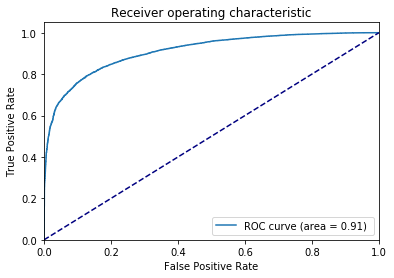

In [79]:
plot_roc_curve(clf, X_test_list = [x_test], Y_test_list = [y_test])

In [80]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [81]:
def plot_gender_roc_curves(trained_predictor, X_test, Y_test):
    """
    Plots the ROC curve for each gender demographic
    """
    combined = pd.concat([X_test, Y_test], axis=1)
    x_test_list, y_test_list, gender_labels = [], [], []
    for gender, gender_label in (("FEMALE", FEMALE_LABEL), ("MALE", MALE_LABEL)):
        with_gender = combined[combined['sex'] == gender_label]
        x_test = with_gender.drop(['salary'], axis=1)
        y_test = with_gender['salary']
        x_test_list.append(x_test)
        y_test_list.append(y_test)
        gender_labels.append(gender)
    plot_roc_curve(predictor, X_test_list=x_test_list, Y_test_list=y_test_list,label_list=gender_labels)

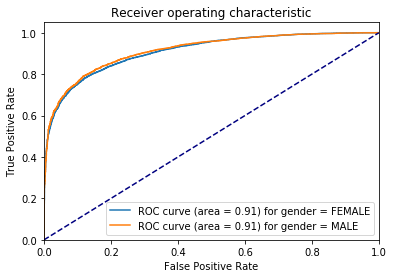

In [82]:
plot_gender_roc_curves(predictor, x_test, y_test)

# VI.1 Bias mitigation through fair model selection

In this section, we explore different model choices, and look at how model choice affects different metrics. We first start by exploring a short overview of the problem group and it's corresponding algorithm family. Based on that, we will then explore different algorithms for classifications, and understand how they perform overall, and for different demographics over several training sessions.

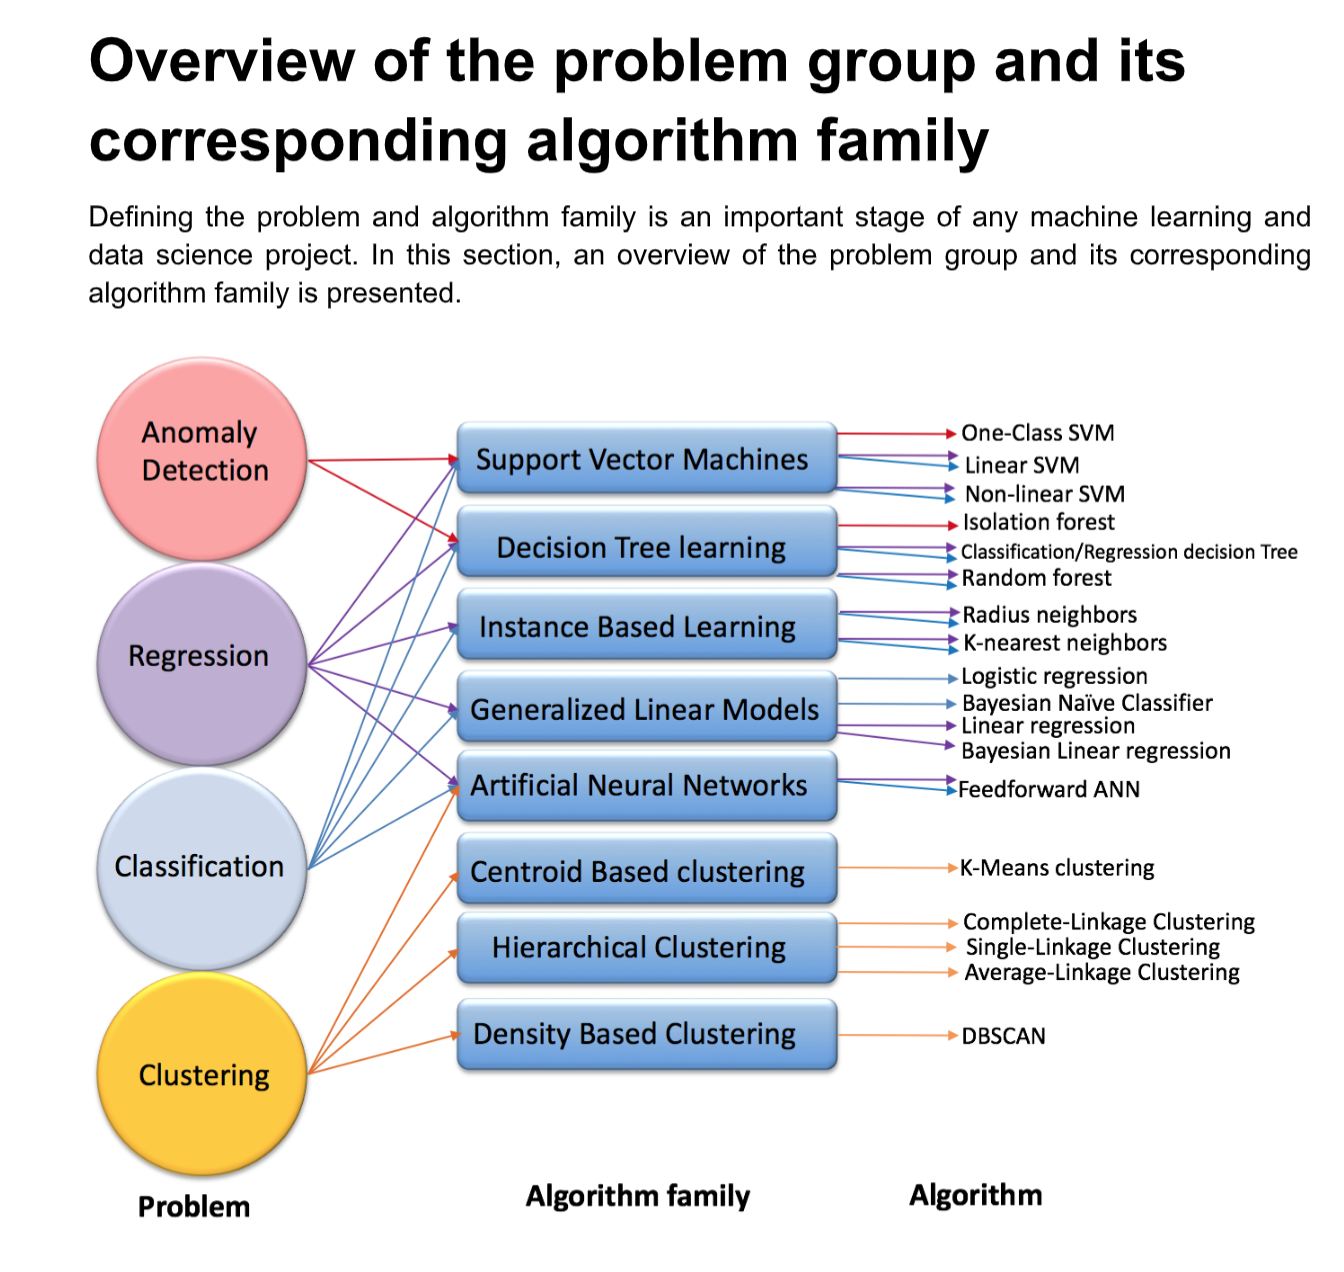

In [83]:
from IPython.display import Image
Image(filename='images/ml_problem_groups.png', width= 500, height= 500, metadata={'align':'center'})

This is a classification problem, therefore, the different classifiers that we can use are 

- Support Vector Machines(SVMs), 
- Decision tree learners, 
- Instance based learners, 
- Generalized linear models, and 
- Artificial neural networks. 

We are going to use one from each category, in order to get a comparison of how these models perform

In [84]:
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

In [124]:
LR_MAX_ITER=1000

In [125]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav3)

In [126]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER) # GLM
rf = RandomForestClassifier(n_estimators=50, random_state=1) # Random Forest
gnb = GaussianNB() # GLM
mlp = MLPClassifier(max_iter=MLP_MAX_ITER)  # ANN
svc = svm.SVC() # SVM
knc = KNeighborsClassifier(n_neighbors=5)
for model in [lr, rf, gnb, mlp, svc, knc]:
    model.fit(x_train, y_train)

/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [127]:
for model_name, model in [('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc), ('knc', knc)]:
    print(model_name, ' accuracy: ', accuracy_score(y_test, model.predict(x_test)))

LR  accuracy:  0.8385812842738369
RF  accuracy:  0.830974703697152
GNB  accuracy:  0.720767733946577
MLP  accuracy:  0.8335397134264992
svc  accuracy:  0.8423845745621794
knc  accuracy:  0.820714664779763


In [128]:
print("Got here")

Got here


# VI.2 Debiasing through multi-model architecture

A multi-model architecture combines different machine learning models, and makes a prediction by taking into account the predictions of multiple models.

There are different ways in which a multi-model architecture can make a decision, but here, we will be looking at a Voting classifier, that uses either the **Soft Votingrule** or **Majority/Hard voting rule** to make predictions.  In Soft-Voting, outputs fom multiple models are averaged. In the majority rule, the majority output/prediction wins.

See [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 

In [129]:
from sklearn.ensemble import VotingClassifier

In [130]:
def default_voting_classifier(voting='hard'):
    lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER)
    rf = RandomForestClassifier(n_estimators=50, random_state=1)
    gnb = GaussianNB()
    mlp = MLPClassifier(max_iter=MLP_MAX_ITER)
    svc = svm.SVC(probability = voting != 'hard')
    knc = KNeighborsClassifier(n_neighbors=5)
    voter = VotingClassifier(estimators=[('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc)], voting=voting)
    
    return voter

In [131]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav3)

In [132]:
hardvoter = default_voting_classifier(voting='hard')
softvoter = default_voting_classifier(voting='soft')
for model in [hardvoter, softvoter]:
    model.fit(x_train, y_train)

/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [133]:
print('Hard voting accuracy ', accuracy_score(y_test, hardvoter.predict(x_test)))
print('Soft voting accuracy ', accuracy_score(y_test, softvoter.predict(x_test)))

Hard voting accuracy  0.8396426676101185
Soft voting accuracy  0.8344241995400672


You might have noticed that training might take some time. Sometimes it is very useful to store trained models or other statistics to persistent storage, to avoid retraining. Let's implement functionality for that

In [134]:
# Model persistence
import pickle

class Persistence:
    """
    Implements model persistence functionality
    """
    def __init__(self):
        pass
    
    @staticmethod 
    def storeObject(_object, filename):
        pickle_out = open(filename,"wb")
        pickle.dump(_object, pickle_out)
        pickle_out.close()
    
    @staticmethod
    def loadObjects(filenames=None):
        result = []
        for filename in filenames:
            result.append(pickle.load(open(filename, 'rb')))
        return result
    
    @staticmethod
    def storeOrLoad(store=False, load=False, names=None, objects=None):
        """
        Returns file names if storing, returns objects if reading
        """
        if store or load:
            assert store != load, 'Cannot store and load'
        if store:
            for _object, name in zip(objects, names):
                Persistence.storeObject(_object, name)
            return 'Stored'
        if load:
            read = Persistence.loadObjects(filenames=names)
            return read

In [135]:
modelNames = ['LR', 'RF', 'GNB', 'MLP', 'SVC', 'hard_voter', 'soft_voter']
models = [lr, rf, gnb, mlp, svc, hardvoter, softvoter]

In [136]:
summaries = []
for model, modelname in zip(models, modelNames):
    summaries.append(evaluate_predictor_performance(model.predict(x_test), x_test, y_test))

# VII. Comparing model performance for 1 training session

## Overall Accuracy

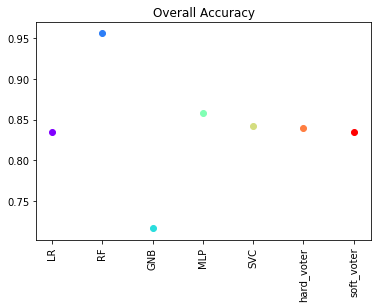

In [137]:
overall_accuracies = [summary['accuracy_overall'] for summary in summaries]
plot_comparisons(modelNames, overall_accuracies, "Overall Accuracy", rotation='vertical')

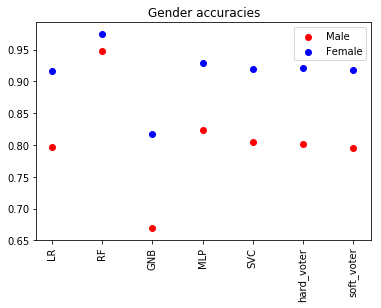

In [138]:
gender_accuracies = [[summary['accuracy_Male'] for summary in summaries], [summary['accuracy_Female'] for summary in summaries]]
plot_comparisons_groups(modelNames, gender_accuracies, "Gender accuracies", rotation='vertical')

## Positive and negative rates accross each demographic

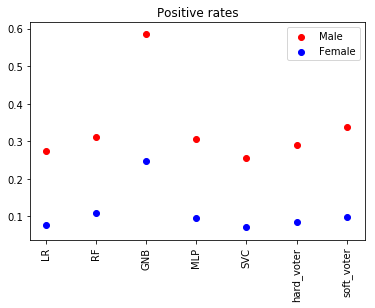

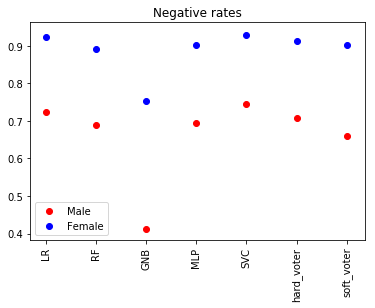

In [139]:
plot_model_gender_metrics('positive_rate', summaries, modelNames, "Positive rates", rotation='vertical')
plot_model_gender_metrics('negative_rate', summaries, modelNames, "Negative rates", rotation='vertical')

## True positive and true negative rates across each demographic

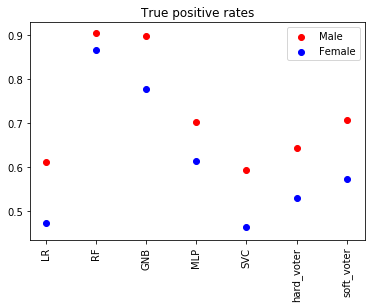

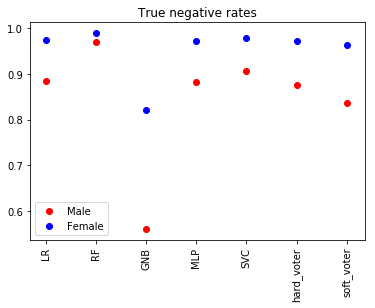

In [140]:
plot_model_gender_metrics('true_positive_rate', summaries, modelNames, "True positive rates", rotation='vertical')
plot_model_gender_metrics('true_negative_rate', summaries, modelNames, "True negative rates", rotation='vertical')

# VIII.Comparing model performance over multiple training sessions

From a single training session, the results are random, therefore our conclusion on the which model performs best is still weak. Doing more than a single training sessions helps get a better idea of what models performs best in the average case.

We first start by implementing functionality for training instances of a model class, and summarizing the results over multiple traning sessions

In [141]:
def get_model_class_summaries(model_class, dataset, training_sessions, *args, **kwargs):
    """
    Repeatedly sample from the dataset, train, test and return summary statistics
    """
    assert training_sessions >= 1, "Must train at least once"
    
    Xvals, Yvals = dataset
    summaries = []
    for session in range(training_sessions):
        x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=.25)
        model = model_class(*args, **kwargs)
        model.fit(x_train, y_train)
        
        evaluation = evaluate_predictor_performance(model.predict(x_test), x_test, y_test)
        summaries.append(evaluation)
        
    assert len(summaries) == training_sessions
    return summaries

Let's now get an idea of what the training summaries are going to look like. We do this by traning an instance of MLPClassifier for 3 times, and aggregating the summaries

In [142]:
dataset = datav3.copy()
Xvals=dataset.drop(["salary"], axis=1)
Yvals = dataset["salary"]
some_summaries = get_model_class_summaries(MLPClassifier, (Xvals, Yvals), 2, max_iter=MLP_MAX_ITER)
some_summaries[:2]

[{'accuracy_overall': 0.8332743675924288,
  'accuracy_Female': 0.9119688975284643,
  'accuracy_Male': 0.7964957819597663,
  'positive_rate_Female': 0.10413773951680089,
  'positive_rate_Male': 0.3047371836469825,
  'negative_rate_Female': 0.8958622604831991,
  'negative_rate_Male': 0.6952628163530176,
  'true_positive_rate_Female': 0.568075117370892,
  'true_negative_rate_Female': 0.9581102362204724,
  'true_positive_rate_Male': 0.6595744680851063,
  'true_negative_rate_Male': 0.8601026420832542},
 {'accuracy_overall': 0.8307978064744383,
  'accuracy_Female': 0.9031903190319032,
  'accuracy_Male': 0.7964797913950457,
  'positive_rate_Female': 0.10121012101210121,
  'positive_rate_Male': 0.2831812255541069,
  'negative_rate_Female': 0.8987898789878987,
  'negative_rate_Male': 0.716818774445893,
  'true_positive_rate_Female': 0.5188679245283019,
  'true_negative_rate_Female': 0.9539227895392279,
  'true_positive_rate_Male': 0.6275574112734864,
  'true_negative_rate_Male': 0.8731753554502

# Aggregate results for single-model architectures

In [143]:
single_model_name_classes_args_kwargs = [
    ['LR', LogisticRegression,     [], {'solver': 'lbfgs', 'multi_class': 'multinomial', 'random_state':1, 'max_iter':LR_MAX_ITER}], 
    ['RF', RandomForestClassifier, [], {'n_estimators':50, 'random_state':1}], 
    ['GNB', GaussianNB,             [], {}],
    ['MLPC', MLPClassifier,          [], {'max_iter':MLP_MAX_ITER}], 
    ['SVC', svm.SVC,                [], {}]
]

In [144]:
single_model_summaries = []

In [145]:
runLoop = True # simply set runLoop to False to avoid iterations
if runLoop:
    for name, model_class, args, kwargs in single_model_name_classes_args_kwargs:
        model_class_summaries = get_model_class_summaries(model_class, (Xvals, Yvals), 5, *args, **kwargs)
        single_model_summaries.append((name, model_class_summaries))

/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/

In [146]:
store = True # Change the flag to store the summaries
if store:
    Persistence.storeOrLoad(store=True, names=['single_model_summaries'], objects = [single_model_summaries])

In [147]:
voting_model_name_classes_args_kwargs = [
    ['hard_voting', default_voting_classifier, [], {'voting':'hard'}],
    ['soft_voting', default_voting_classifier, [], {'voting':'soft'}]
]

# Aggregate results for multi-model architectures

In [148]:
voting_model_summaries = []

In [149]:
runLoop = True
if runLoop:
    for name, model_class, args, kwargs in voting_model_name_classes_args_kwargs:
        model_class_summaries = get_model_class_summaries(model_class, (Xvals, Yvals), 5, *args, **kwargs)
        voting_model_summaries.append((name, model_class_summaries))

/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/audace/anaconda3/lib/python3.7/site-packages/

In [150]:
assert len(voting_model_summaries) > 0
Persistence.storeOrLoad(store=True, names=['voting_model_summaries'], objects=[voting_model_summaries])

'Stored'

In [151]:
def extract_treatment_differences(summaries):
    """
    Extract treatment difference(male-female) from a performance summary
    """
    differences = []
    for summary_dict in summaries:
        gender_attrs = set()
        for gender_key in summary_dict:
            if '_Male' in gender_key:
                gender_attrs.add(gender_key[:gender_key.rindex('_')])
        value_dict = {}
        for gender_attr in gender_attrs:
            value_dict[gender_attr] = summary_dict[gender_attr+"_Male"] - summary_dict[gender_attr+ "_Female"]
        differences.append(value_dict)
    return differences

In [152]:
all_model_summaries = single_model_summaries + voting_model_summaries

In [153]:
store = True # set to True to store all model summaries
if store:
    Persistence.storeOrLoad(store=True, names=['all_model_summaries'], objects=[all_model_summaries])

In [154]:
load = True # Set to true to load stored models
if load:
    all_model_summaries = Persistence.storeOrLoad(load=load, names=['all_model_summaries'])[0]

In [155]:
all_model_summaries[-2:]

[('hard_voting',
  [{'accuracy_overall': 0.8436228551211746,
    'accuracy_Female': 0.9132002218524681,
    'accuracy_Male': 0.811038961038961,
    'positive_rate_Female': 0.08901830282861897,
    'positive_rate_Male': 0.29194805194805196,
    'negative_rate_Female': 0.910981697171381,
    'negative_rate_Male': 0.708051948051948,
    'true_positive_rate_Female': 0.5093023255813953,
    'true_negative_rate_Female': 0.9678841309823678,
    'true_positive_rate_Male': 0.6668068994530921,
    'true_negative_rate_Male': 0.8754461769678753},
   {'accuracy_overall': 0.8406156023350433,
    'accuracy_Female': 0.923097679438748,
    'accuracy_Male': 0.8003947368421053,
    'positive_rate_Female': 0.08148947652455478,
    'positive_rate_Male': 0.2768421052631579,
    'negative_rate_Female': 0.9185105234754453,
    'negative_rate_Male': 0.7231578947368421,
    'true_positive_rate_Female': 0.5201900237529691,
    'true_negative_rate_Female': 0.9747336377473363,
    'true_positive_rate_Male': 0.6245

In [156]:
all_model_differences = []

In [157]:

for model_name, model_summaries in all_model_summaries:
    differences = extract_treatment_differences(model_summaries)
    all_model_differences.append((model_name, differences))
    

In [158]:
all_model_differences[:1]

[('LR',
  [{'negative_rate': -0.20683217534791754,
    'accuracy': -0.12466094085284485,
    'positive_rate': 0.2068321753479175,
    'true_negative_rate': -0.09438032669421881,
    'true_positive_rate': 0.1583740904210903},
   {'negative_rate': -0.19307566208870885,
    'accuracy': -0.11653092278576449,
    'positive_rate': 0.19307566208870885,
    'true_negative_rate': -0.08749402600612355,
    'true_positive_rate': 0.14467151111325705},
   {'negative_rate': -0.18550039676619734,
    'accuracy': -0.11668533328557196,
    'positive_rate': 0.18550039676619728,
    'true_negative_rate': -0.08225080567061605,
    'true_positive_rate': 0.11156604581460072},
   {'negative_rate': -0.182964122890388,
    'accuracy': -0.11619431005777625,
    'positive_rate': 0.18296412289038794,
    'true_negative_rate': -0.08336052330878796,
    'true_positive_rate': 0.1193370739817124},
   {'negative_rate': -0.19257954087797025,
    'accuracy': -0.10390877827382228,
    'positive_rate': 0.1925795408779702,

# Plotting model performance differences

We now implement functionalities for plotting the aggregated statistics to get a visual understanding of each model's performance in terms of gender disparity

In [159]:
def get_model_values_for_feature(feature, nsp, abs_val=False):
    """
    Inputs: 
        nsp = name summary pairs
    """
    model_names = [model_summary[0] for model_summary in nsp]
    model_summary_lists = [model_summary[1] for model_summary in nsp] # Each element is a list of dicts
    model_y_values = []
    for model_summary_list in model_summary_lists:
        values = [abs(model_summary[feature]) if abs_val else model_summary[feature] for model_summary in model_summary_list]
        model_y_values.append(values)
    return model_names, model_y_values

def plot_model_values_for_feature(model_names, model_y_values, title, rotation='vertical'):

    indices = list(range(len(model_names)))
    
    colors = cm.rainbow(np.linspace(0, 1, len(indices)))
    
    fig, ax = plt.subplots()
    
    for index in indices:
        for y_value in model_y_values[index]:
            ax.scatter(index, abs(y_value), color=colors[index], label=model_names[index])
    plt.xticks(indices, model_names, rotation=rotation)
    #plt.yticks([0])
    plt.title(title)
    
    plt.show()
    
def plot_feature_differences(feature_name, model_differences, title):
    model_names, model_y_values = get_model_values_for_feature(feature_name, all_model_differences)
    plot_model_values_for_feature(model_names, model_y_values, title)

# Accuracy difference comparison

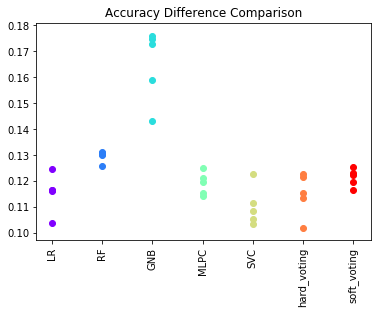

In [160]:
plot_feature_differences('accuracy', all_model_differences, 'Accuracy Difference Comparison')

# Positive and negative rate difference comparison

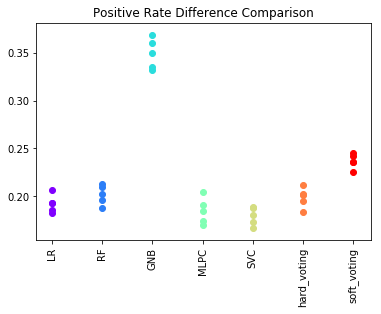

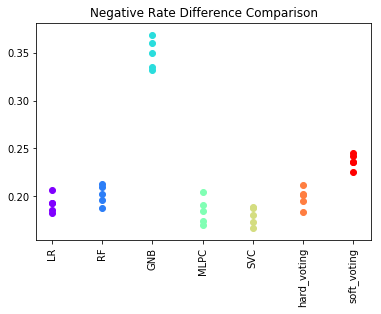

In [161]:
pl = [('positive_rate', 'Positive Rate'), ('negative_rate', 'Negative Rate')]
for feature, title in pl:
    plot_feature_differences(feature, all_model_differences, title+ ' Difference Comparison')

# True positive and true negative rate difference comparison

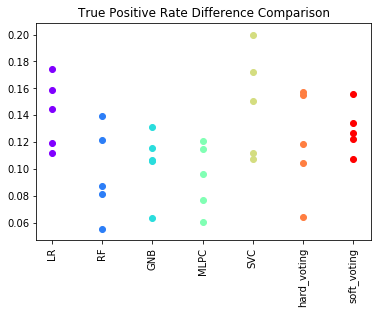

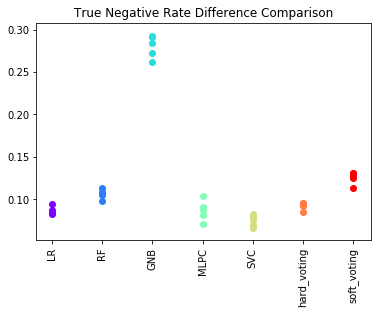

In [162]:
pl = [('true_positive_rate', 'True Positive Rate'), ('true_negative_rate', 'True Negative Rate')]
for feature, title in pl:
    plot_feature_differences(feature, all_model_differences, title+ ' Difference Comparison')

# 4. Conclusion

We explored database re-balancing as a way to mitigate bias from our predictions. More advanced ways to mitigate bias in Machine Learning include custom loss functions and adversarial debiasing. To explore these techniques, follow the links below:

4.1 [Mitigating unwanted biases in Machine Learning through custom loss functions]()

4.2 [Mitigating unwanted biases in Machine Learning by adversarial learning]()

# 5. References

[1]. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2]. [Google AI blog, Equal opportunity in Machine Learning](https://ai.googleblog.com/2016/10/equality-of-opportunity-in-machine.html)

[3]. [Towards Data Science, a Tutoria on Fairness in Machine Learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)

[4]. [Jeremy Kun, One definition of fairness in machine learning](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)

[5]. [Learning Curves for Machine Learning](https://www.dataquest.io/blog/learning-curves-machine-learning)